In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from utils.basics.data_org import curr_computer, move_subfolders
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.photometry.preprocessing import *
from utils.photometry.plot_utils import align_signal_to_events
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
# %matplotlib inline
%matplotlib widget

In [2]:
session = 'm699461d20231222'
label = 'CombinewithKH'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)


Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


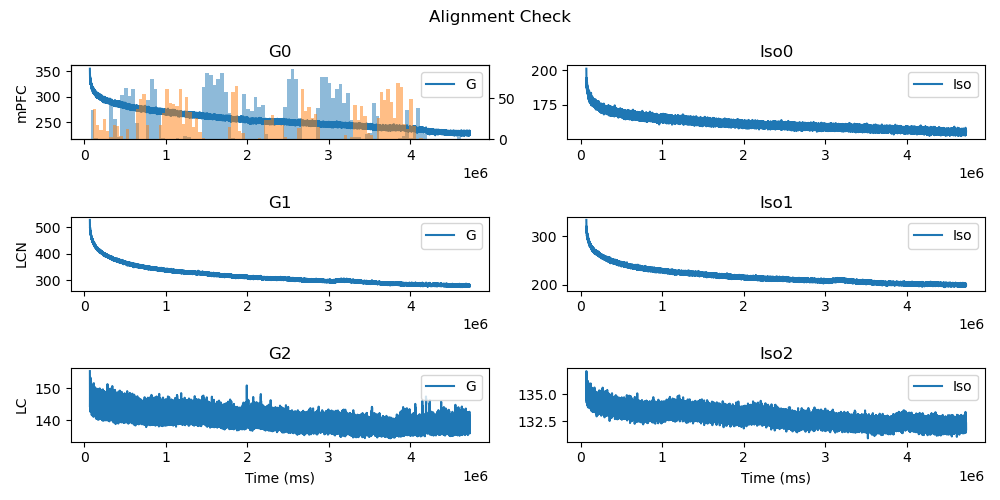

In [18]:
def plot_FP_with_licks(session, label, region):
    session_df, licks_L, licks_R = load_session_df(session)
    session_dir = parse_session_string(session)
    signal_region_raw = load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = False)
    signal_region_prep = preprocess_signal(session, signal_region_raw, plot=False)
    licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
    parsed_licks_L, _ = parse_lick_trains(licks_L)
    parsed_licks_R, _ = parse_lick_trains(licks_R)
    trial_starts = session_df['CSon']
    licks_in_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_in_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    fig = plt.figure(figsize=(20, 10))
    colorL = 'b'
    colorR = 'r'
    all_channels = [key for key, value in signal_region_prep.items() if 'time' not in key]
    gs = GridSpec(len(all_channels), 5, figure=fig)
    for channel_id, channel in enumerate(all_channels):
        signal = signal_region_prep[channel][region]
        ax = fig.add_subplot(gs[channel_id, 0])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_L['train_starts'], ax = ax, legend = 'L', color = colorL)
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_R['train_starts'], ax = ax, legend = 'R', color = colorR)
        ax.legend()
        ax.set_title(f'All licks')
        ax.set_ylabel(channel)
        # in vs out trial L
        ax = fig.add_subplot(gs[channel_id, 1])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_L, ax = ax, color = colorL, legend = 'in')
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial L')
        # in vs out trial R
        ax = fig.add_subplot(gs[channel_id, 2])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_R, ax = ax, color = colorL, legend = 'in')     
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial R')
    
    fig.suptitle(f'{session}_{region}')
    fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_{region}_FP_licks.pdf'))


In [ ]:
plot_FP_with_licks(session, label, 'mPFC')

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:49: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Text(0.5, 1.0, 'In vs out trial R')

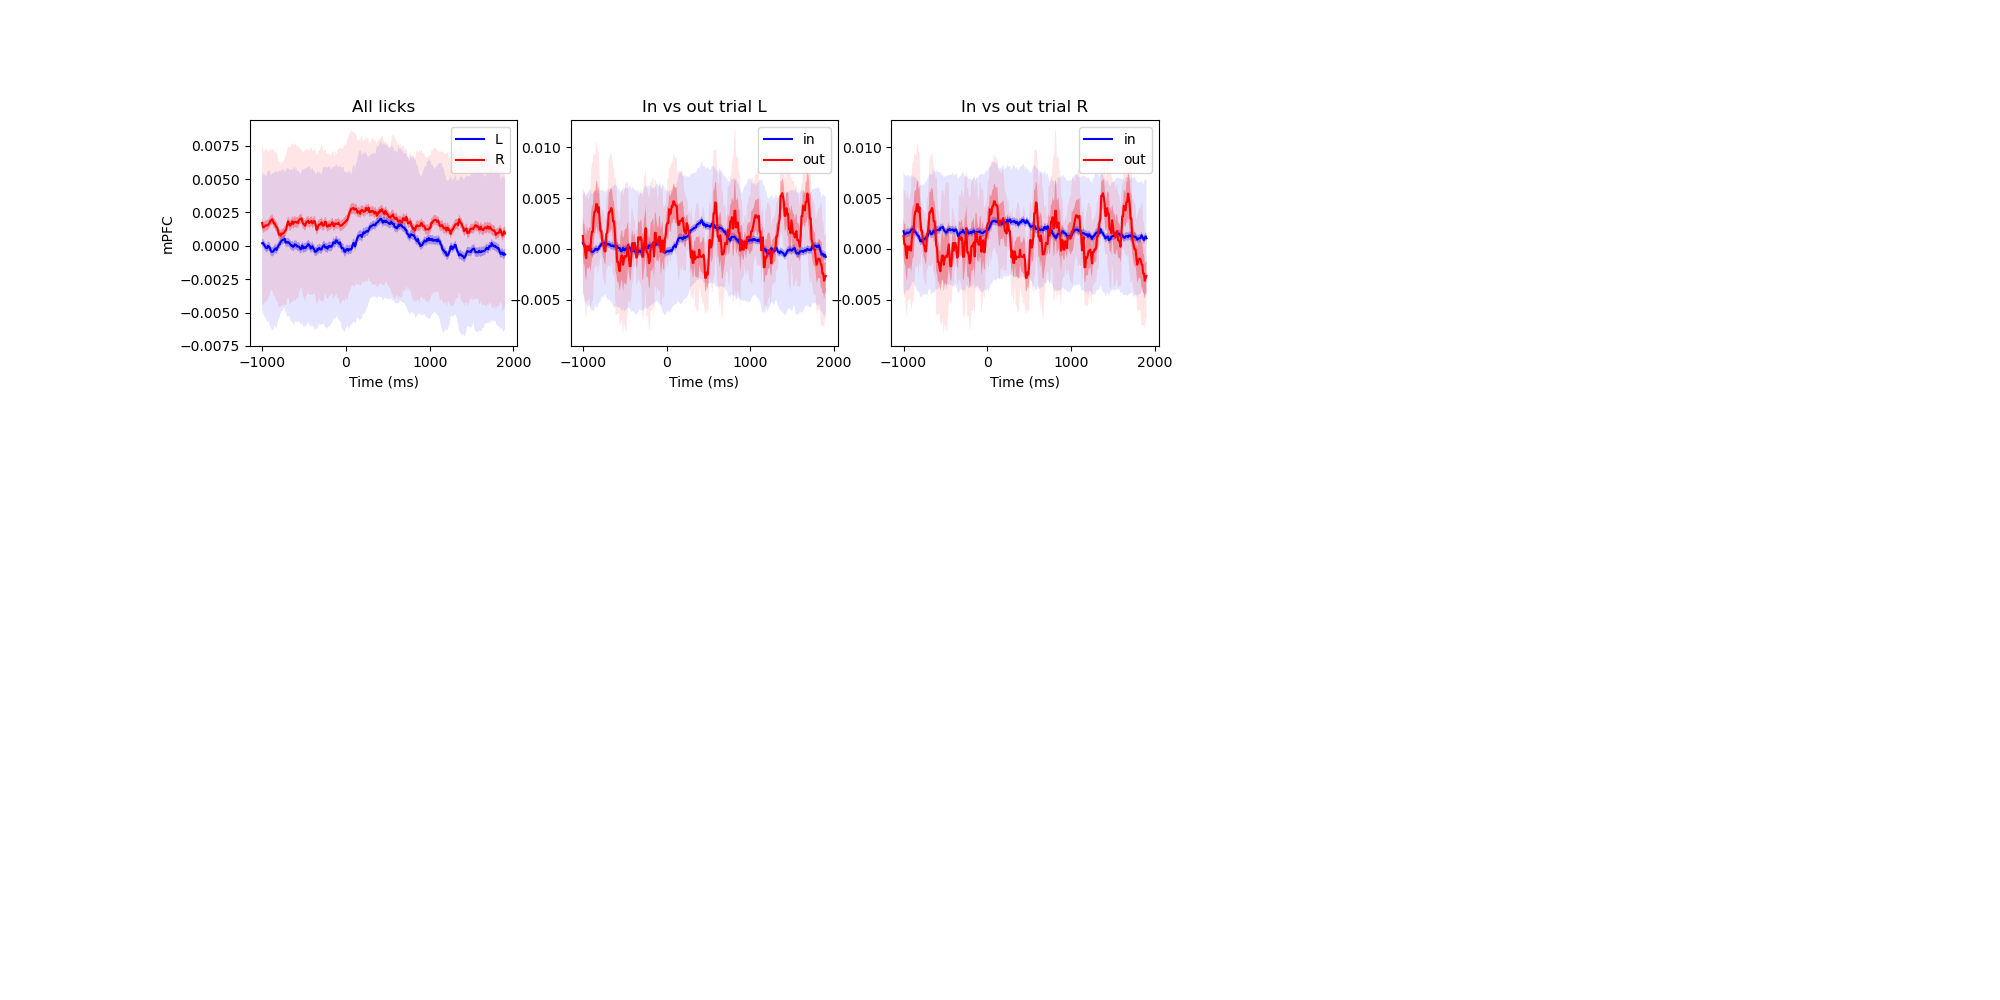

In [16]:

colorL = 'b'
colorR = 'r'
region = 'mPFC'
channel = 'G'
channel_id = 0

signal = signal_region_prep[channel][region]
aligned_matrix, mean_psth, time_bins, ax = align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_L['train_starts'], ax = ax, legend = 'L', color = colorL)
aligned_matrix, mean_psth, time_bins, ax = align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_R['train_starts'], ax = ax, legend = 'R', color = colorR)
ax.legend()
ax.set_title(f'All licks')
ax.set_ylabel(region)
# in vs out trial L
ax = fig.add_subplot(gs[channel_id, 1])
align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_L, ax = ax, color = colorL, legend = 'in')
align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
ax.legend()
ax.set_title(f'In vs out trial L')
# in vs out trial R
ax = fig.add_subplot(gs[channel_id, 2])
align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_R, ax = ax, color = colorL, legend = 'in')     
align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
ax.legend()
ax.set_title(f'In vs out trial R')



In [ ]:
vector = np.array([100000, 200000, 300000])  # Example vector, replace with your actual vector
selected_elements = []


In [6]:
parsed_licks_L.keys()

dict_keys(['lick_peak_times', 'lick_peak_amplitudes', 'train_starts', 'train_ends'])